# Drop features

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

from sklearn.preprocessing import LabelEncoder

In [11]:
df = pd.read_csv('../data/data_cleaned.csv', sep=',')

# encode target variable: 0: dropout, 1: enrolled, 2: graduated
le = LabelEncoder()
df['Target_encoded'] = le.fit_transform(df['Target'])

# Drop 'Target' variable
df.drop('Target', axis = 1, inplace = True)

# Change data types of columns that should be categorical
col = ['Marital_status', 'Application_mode', 'Course', 'Previous_qualification',
       'Mother_qualification', 'Father_qualification', 'Mother_occupation',
       'Father_occupation','Target_encoded']

df[col] = df[col].astype('category')


stud_selected = df.drop(['Nationality', 'International', 'Educational_special_needs','Marital_status', 'Inflation_rate'], axis = 1)  
stud_selected.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4424 entries, 0 to 4423
Data columns (total 32 columns):
 #   Column                                        Non-Null Count  Dtype   
---  ------                                        --------------  -----   
 0   Application_mode                              4424 non-null   category
 1   Application_order                             4424 non-null   int64   
 2   Course                                        4424 non-null   category
 3   Daytime/evening_attendance                    4424 non-null   int64   
 4   Previous_qualification                        4424 non-null   category
 5   Previous_qualification_grade                  4424 non-null   float64 
 6   Mother_qualification                          4424 non-null   category
 7   Father_qualification                          4424 non-null   category
 8   Mother_occupation                             4424 non-null   category
 9   Father_occupation                             4424 n

# Data splitting

X_train shape: (3539, 31)
X_test shape: (885, 31)
y_train shape: (3539,)
y_test shape: (885,)


C:\Users\Martina\AppData\Local\Temp\ipykernel_11940\3702010728.py:27: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.assign(Percentage=100 * x['Count'] / x['Count'].sum()))


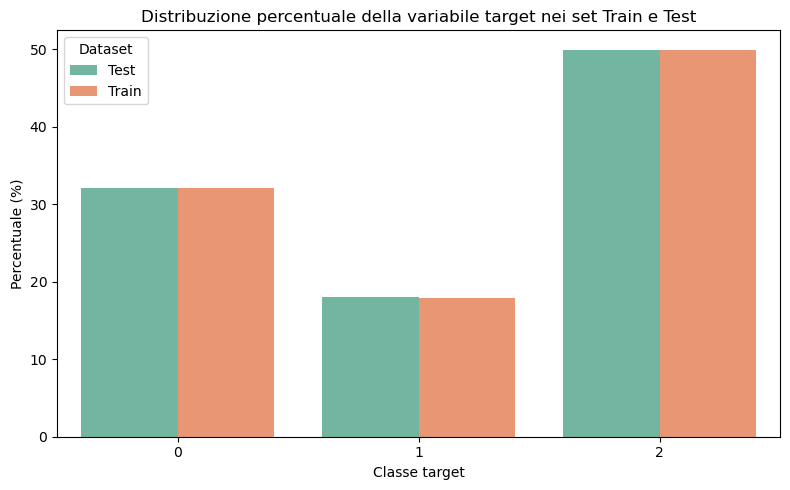

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_sample_weight

X = stud_selected.drop('Target_encoded', axis=1)  
y = stud_selected['Target_encoded']  

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

# === Visualizzazione distribuzione target ===
# Ricrea il DataFrame con etichette
dist_df = pd.DataFrame({
    'Set': ['Train'] * len(y_train) + ['Test'] * len(y_test),
    'Target': pd.concat([y_train, y_test])
})

# Calcola le percentuali
percent_df = (
    dist_df.value_counts(['Set', 'Target'])
    .reset_index(name='Count')
    .groupby('Set')
    .apply(lambda x: x.assign(Percentage=100 * x['Count'] / x['Count'].sum()))
    .reset_index(drop=True)
)

# Plot percentuale
plt.figure(figsize=(8, 5))
sns.barplot(data=percent_df, x='Target', y='Percentage', hue='Set', palette='Set2')
plt.title('Distribuzione percentuale della variabile target nei set Train e Test')
plt.xlabel('Classe target')
plt.ylabel('Percentuale (%)')
plt.legend(title='Dataset')
plt.tight_layout()
plt.show()

In [4]:
from collections import Counter

print(Counter(y_train))

Counter({2: 1767, 0: 1137, 1: 635})


# Model comparison

In [ ]:
#  Model Comparison for Multi-Class Imbalanced Classification
# ============================================
# Imports
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingGridSearchCV
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.metrics import f1_score, balanced_accuracy_score, roc_auc_score, classification_report
import joblib
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier)
from sklearn.svm import SVC

from FeatTransformer import FeatTransformer
from preprocessing import preprocessor

# Cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Models and refined hyperparameter grids
def get_estimators_and_grids():
    estimators = {
        'decision_tree': DecisionTreeClassifier(random_state=42, class_weight='balanced'),
        'random_forest': RandomForestClassifier(random_state=42, class_weight='balanced'),
        'svm': SVC(probability=True, random_state=42),
        'gradient_boosting': GradientBoostingClassifier(random_state=42),
        'xgboost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
        'lightgbm': LGBMClassifier(random_state=42),
        'catboost': CatBoostClassifier(verbose=0, random_state=42, allow_writing_files=False)
    }

    param_grids = {
        'decision_tree': {
            'model__max_depth': [None, 5, 10, 15],
            'model__min_samples_split': [2, 5, 10],
            'model__min_samples_leaf': [1, 2, 4]
        },
        'random_forest': {
            'model__n_estimators': [100, 200, 300],
            'model__max_depth': [None, 10, 20],
            'model__max_features': ['sqrt', 'log2']
        },
        'svm': {
            'model__C': [0.1, 1, 10],
            'model__kernel': ['linear', 'rbf'],
            'model__gamma': ['scale', 'auto']
        },
        'gradient_boosting': {
            'model__n_estimators': [100, 200],
            'model__learning_rate': [0.01, 0.1],
            'model__max_depth': [3, 5]
        },
        'xgboost': {
            'model__n_estimators': [100, 200],
            'model__learning_rate': [0.01, 0.1],
            'model__max_depth': [3, 5],
            'model__subsample': [0.8, 1]
        },
        'lightgbm': {
            'model__n_estimators': [100, 200],
            'model__learning_rate': [0.01, 0.1],
            'model__num_leaves': [31, 50],
            'model__max_depth': [-1, 5]
        },
        'catboost': {
            'model__iterations': [100, 200],
            'model__learning_rate': [0.01, 0.1],
            'model__depth': [6, 10]
        }
    }
    return estimators, param_grids

# Build the imbalanced-learn pipeline
def build_pipeline(model):
    steps = [
        ('feature_transformer', FeatTransformer(drop_originals=True)),
        ('preprocessing', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('model', model)
    ]
    return ImbPipeline(steps)

# Tuning, evaluation, and saving function
def tune_and_evaluate(name, estimator, param_grid):
    print(f"Tuning {name}...")
    pipeline = build_pipeline(estimator)
    search = HalvingGridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        cv=cv,
        scoring='f1_macro',
        factor=2,
        random_state=42,
        verbose=0,
        n_jobs=-1
    )
    search.fit(X_train, y_train)
    best = search.best_estimator_
    print(f"Best params for {name}: {search.best_params_}")

    # Evaluate on test set
    y_pred = best.predict(X_test)
    y_prob = best.predict_proba(X_test)

    metrics = {
        'balanced_accuracy': balanced_accuracy_score(y_test, y_pred),
        'f1_macro': f1_score(y_test, y_pred, average='macro'),
        'roc_auc_macro': roc_auc_score(pd.get_dummies(y_test), y_prob, average='macro')
    }
    report = classification_report(y_test, y_pred, output_dict=True)
    per_class_f1 = {cls: report[cls]['f1-score'] for cls in report if cls not in ['accuracy', 'macro avg', 'weighted avg']}
    metrics['per_class_f1'] = per_class_f1

    # Save best model
    joblib.dump(best, f"../models/best_model_{name}.joblib")
    print(f"Saved best_model_{name}.joblib")

    return metrics, best

In [6]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

estimators, grids = get_estimators_and_grids()
results = {}
for name, estimator in estimators.items():
    metrics, _ = tune_and_evaluate(name, estimator, grids[name])
    results[name] = metrics

# Compile and save results
results_df = pd.DataFrame(results).T
print(results_df)
results_df.to_csv('../results/model_comparison_results_2.csv')

Tuning decision_tree...
Best params for decision_tree: {'model__max_depth': 5, 'model__min_samples_leaf': 4, 'model__min_samples_split': 5}
Saved best_model_decision_tree.joblib
Tuning random_forest...
Best params for random_forest: {'model__max_depth': 10, 'model__max_features': 'sqrt', 'model__n_estimators': 300}
Saved best_model_random_forest.joblib
Tuning svm...
Best params for svm: {'model__C': 10, 'model__gamma': 'auto', 'model__kernel': 'rbf'}
Saved best_model_svm.joblib
Tuning gradient_boosting...
Best params for gradient_boosting: {'model__learning_rate': 0.01, 'model__max_depth': 3, 'model__n_estimators': 200}
Saved best_model_gradient_boosting.joblib
Tuning xgboost...
Best params for xgboost: {'model__learning_rate': 0.01, 'model__max_depth': 5, 'model__n_estimators': 200, 'model__subsample': 0.8}
Saved best_model_xgboost.joblib
Tuning lightgbm...


  File "c:\Users\Martina\anaconda3\envs\DMML\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005236 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10922
[LightGBM] [Info] Number of data points in the train set: 5301, number of used features: 100
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No

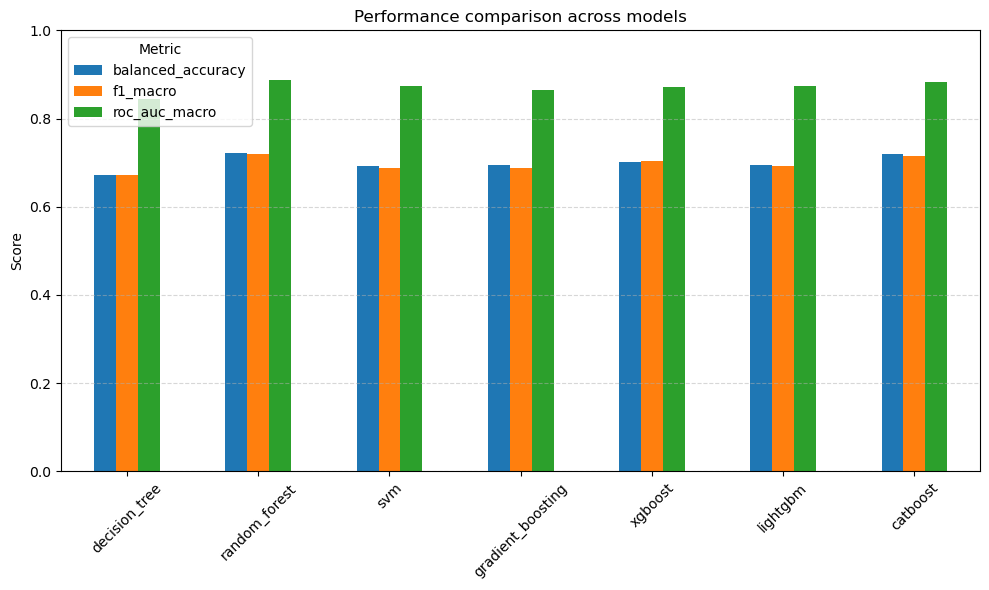

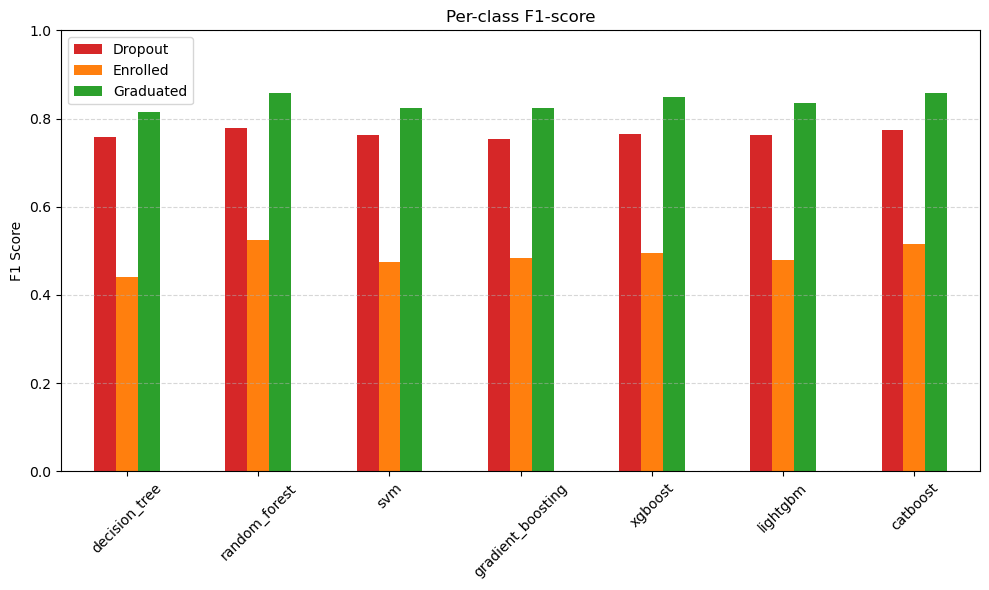

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import ast

# === 1. Carica il file CSV
df = pd.read_csv("../results/model_comparison_results_2.csv", index_col=0)

# === 2. Converte per_class_f1 da stringa a dizionario
df["per_class_f1"] = df["per_class_f1"].apply(ast.literal_eval)

# === 3. Estrai F1 per ciascuna classe in nuove colonne
df["f1_dropout"]   = df["per_class_f1"].apply(lambda d: d.get('0', None))
df["f1_enrolled"]  = df["per_class_f1"].apply(lambda d: d.get('1', None))
df["f1_graduated"] = df["per_class_f1"].apply(lambda d: d.get('2', None))

# === 4. Plot delle metriche principali
metrics = ["balanced_accuracy", "f1_macro", "roc_auc_macro"]
df[metrics].plot(kind="bar", figsize=(10, 6))
plt.title("Performance comparison across models")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.xticks(rotation=45)
plt.legend(title="Metric")
plt.tight_layout()
plt.show()

# === 5. Plot F1 per classe
df[["f1_dropout", "f1_enrolled", "f1_graduated"]].plot(kind="bar", figsize=(10, 6), color=["#d62728", "#ff7f0e", "#2ca02c"])
plt.title("Per-class F1-score")
plt.ylabel("F1 Score")
plt.ylim(0, 1)
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.xticks(rotation=45)
plt.legend(["Dropout", "Enrolled", "Graduated"])
plt.tight_layout()
plt.show()


# Statistical comparison RF-CatBoost

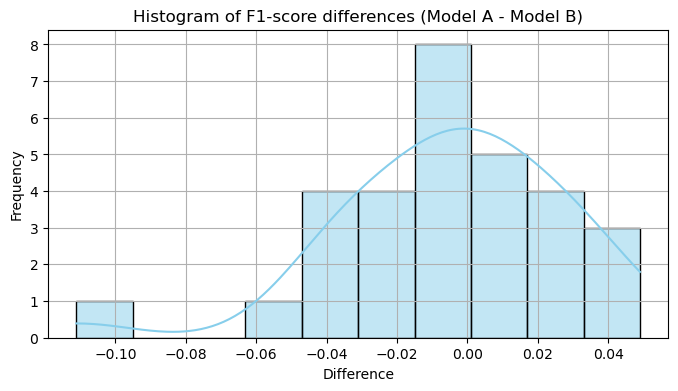

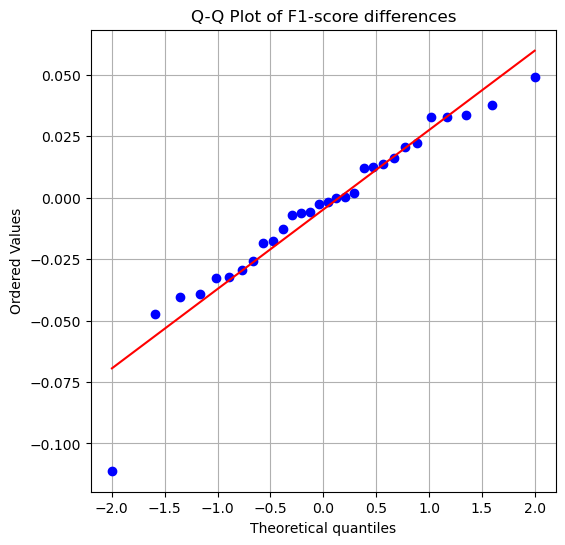

In [ ]:
import numpy as np
import joblib
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold
from scipy.stats import shapiro, ttest_rel, wilcoxon
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.model_selection import RepeatedStratifiedKFold


# === Carica i modelli salvati ===
model_a = joblib.load("../models/best_model_catboost.joblib")
model_b = joblib.load("../models/best_model_random_forest.joblib")


cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)

f1_scores_a = []
f1_scores_b = []

for train_idx, test_idx in cv.split(X_test, y_test):
    X_fold = X_test.iloc[test_idx]
    y_fold = y_test.iloc[test_idx]


    y_pred_a = model_a.predict(X_fold)
    y_pred_b = model_b.predict(X_fold)

    f1_scores_a.append(f1_score(y_fold, y_pred_a, average='macro'))
    f1_scores_b.append(f1_score(y_fold, y_pred_b, average='macro'))

f1_scores_a = np.array(f1_scores_a)
f1_scores_b = np.array(f1_scores_b)

# === Differenze per test statistici ===
diff = f1_scores_a - f1_scores_b


# === Istogramma delle differenze ===
plt.figure(figsize=(8, 4))
sns.histplot(diff, kde=True, bins=10, color='skyblue')
plt.title("Histogram of F1-score differences (Model A - Model B)")
plt.xlabel("Difference")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

# === Q-Q plot ===
plt.figure(figsize=(6, 6))
stats.probplot(diff, dist="norm", plot=plt)
plt.title("Q-Q Plot of F1-score differences")
plt.grid(True)
plt.show()




In [6]:
from scipy.stats import wilcoxon

w_p_value = wilcoxon(diff)
print('Wilcoxon signed-rank test p-value:', w_p_value)

Wilcoxon signed-rank test p-value: WilcoxonResult(statistic=207.0, pvalue=0.6120056137442589)


# Performance evaluation

In [13]:
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score, classification_report
from sklearn.preprocessing import label_binarize
from sklearn.metrics import RocCurveDisplay
import numpy as np


# ==============================
# Confusion Matrix
# ==============================
def confusion_matrix_plot(y_true, y_pred, classes, name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix - {name}")
    plt.show()


# ==============================
# ROC Curve (One-vs-Rest)
# ==============================
def roc_curve_plot(y_true, y_prob, classes, name):

    y_true_bin = label_binarize(y_true, classes=classes)
    n_classes = y_true_bin.shape[1]

    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Traccia le curve ROC per ogni classe
    plt.figure(figsize=(8, 6))
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label=f"Class {classes[i]} (AUC = {roc_auc[i]:.2f})")

    plt.plot([0, 1], [0, 1], "k--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - One-vs-Rest ({name})")
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()





=== Classification Report: Random Forest ===
              precision    recall  f1-score   support

           0     0.8436    0.7218    0.7780       284
           1     0.4769    0.5849    0.5254       159
           2     0.8523    0.8620    0.8571       442

    accuracy                         0.7672       885
   macro avg     0.7243    0.7229    0.7202       885
weighted avg     0.7821    0.7672    0.7721       885



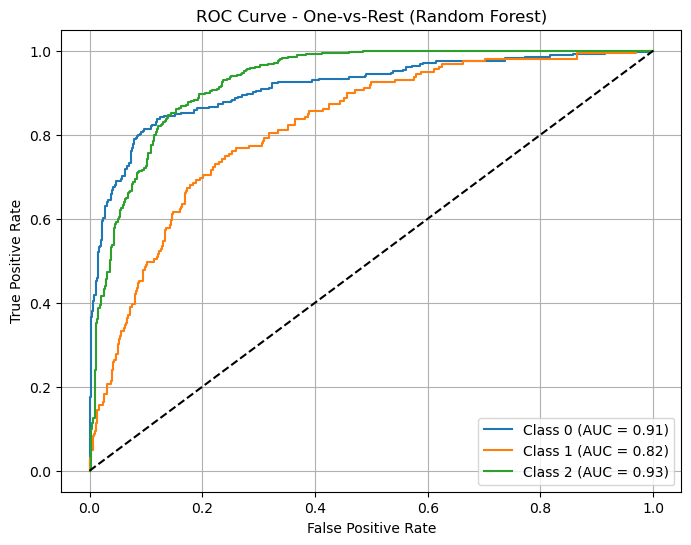

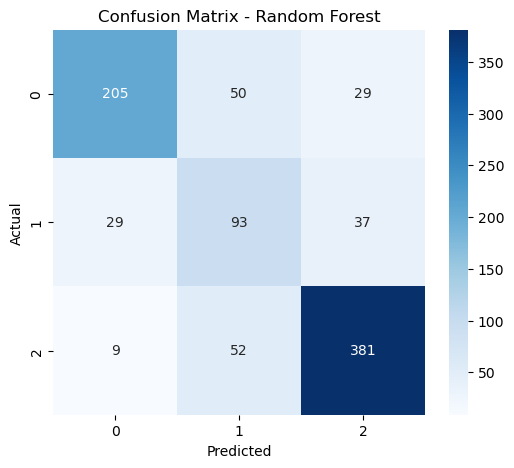

In [14]:
model_rf = joblib.load("../models/best_model_random_forest.joblib")  # Cambia il nome se necessario

y_pred = model_rf.predict(X_test)
y_prob = model_rf.predict_proba(X_test)


print("\n=== Classification Report: Random Forest ===")
print(classification_report(y_test, y_pred, digits=4))

# Plot ROC Curve
roc_curve_plot(y_test, y_prob, model_rf.classes_, "Random Forest")
confusion_matrix_plot(y_test, y_pred, model_rf.classes_, "Random Forest")


=== Classification Report: Catboost ===
              precision    recall  f1-score   support

           0     0.8189    0.7324    0.7732       284
           1     0.4737    0.5660    0.5158       159
           2     0.8594    0.8575    0.8584       442

    accuracy                         0.7650       885
   macro avg     0.7173    0.7186    0.7158       885
weighted avg     0.7771    0.7650    0.7695       885



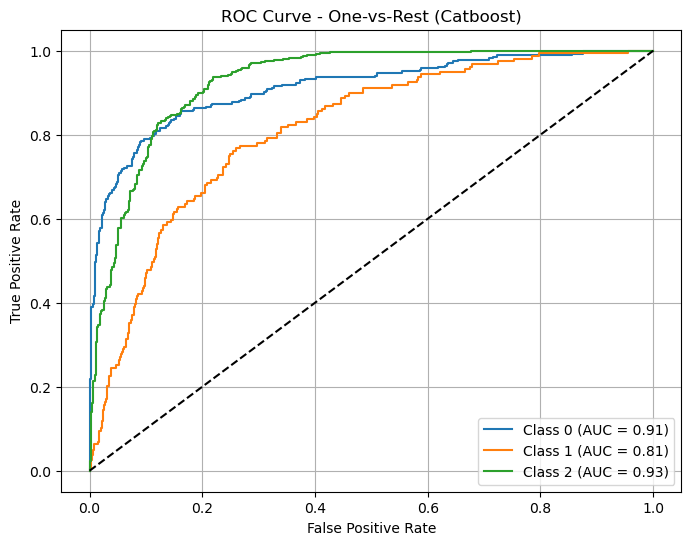

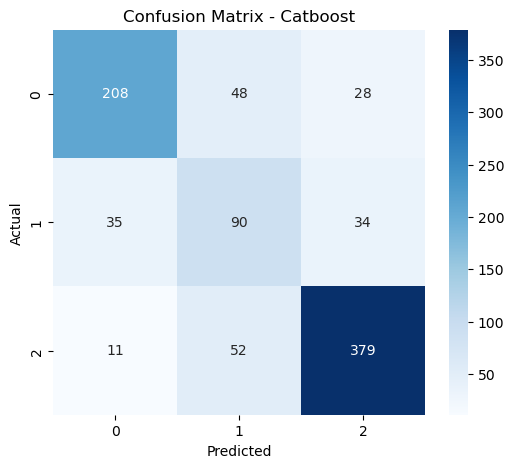

In [ ]:
model_cb= joblib.load("../models/best_model_catboost.joblib") 

y_pred = model_cb.predict(X_test)
y_prob = model_cb.predict_proba(X_test)


print("\n=== Classification Report: Catboost ===")
print(classification_report(y_test, y_pred, digits=4))

# Plot ROC Curve
roc_curve_plot(y_test, y_prob, model_cb.classes_, "Catboost")
confusion_matrix_plot(y_test, y_pred, model_cb.classes_, "Catboost")

# Feature importance

## SHAP

In [ ]:
import joblib
import shap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

model = model_cb
# model= model_rf

X_test_fe = model.named_steps['feature_transformer'].transform(X_test)
X_test_proc = model.named_steps['preprocessing'].transform(X_test_fe)

if hasattr(X_test_proc, "toarray"):
    X_test_proc = X_test_proc.toarray()

# Recupera i nomi delle feature dopo il preprocessing
feature_names = model.named_steps['preprocessing'].get_feature_names_out()

X_shap = pd.DataFrame(X_test_proc, columns=feature_names)

model = model.named_steps['model']

# Usa TreeExplainer per modelli tree-based
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_shap)


joblib.dump(shap_values, "../shap_output/shap_values_cb.joblib")
joblib.dump(explainer, "../shap_output/shap_explainer_cb.joblib")
X_shap.to_csv("../shap_output/X_shap_cb.csv", index=False)
np.save("../shap_output/feature_names_cb.npy", feature_names)



In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re

# Function to get the group name from the column name
def get_group_name(col):
    if col.startswith("oh__"):
        match = re.match(r"oh__([A-Za-z0-9_]+?)_\d+$", col)
        if match:
            return match.group(1)
        else:
            return col.replace("oh__", "")
    elif "__" in col:
        return col.split("__")[1]
    else:
        return col

def plot_shap_values(shap_values, feature_names, model_classes):
# Load SHAP values and feature names
    for i, class_name in enumerate(model_classes):
        print(f"\n🔍 SHAP grouped bar plot for class {class_name}")

        # Load SHAP values for the current class
        shap_vals = shap_values[:, :, i]
        shap_df = pd.DataFrame(np.abs(shap_vals), columns=feature_names)

        grouped_names = [get_group_name(col) for col in shap_df.columns]
        shap_df.columns = grouped_names

        # Group by feature names and calculate mean SHAP values
        shap_grouped = shap_df.groupby(shap_df.columns, axis=1).mean()
        shap_importance = shap_grouped.mean().sort_values(ascending=False)

        
        top_n = 10
        top_shap = shap_importance[:top_n]
        other_sum = shap_importance[top_n:].sum()
        top_shap[f"Sum of {len(shap_importance) - top_n} other features"] = other_sum

        
        plt.figure(figsize=(10, 6))
        top_shap[::-1].plot(kind='barh', color='crimson')
        for j, v in enumerate(top_shap[::-1]):
            plt.text(v + 0.002, j, f"+{v:.2f}", va='center', fontsize=9)
        plt.xlabel("mean(|SHAP value|)")
        plt.title(f"Grouped Feature Importance (SHAP) - Class {class_name}")
        plt.grid(True, axis='x', linestyle='--', alpha=0.6)
        plt.tight_layout()
        plt.show()


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


def plot_shap_aggregated(shap_values, feature_names, class_names):
    aggregated_shap_class_df = []
    for i in range(3):
        # SHAP per la classe i
        shap_vals = shap_values[:, :, i]  
        shap_df = pd.DataFrame(np.abs(shap_vals), columns=feature_names)

        
        grouped_names = [get_group_name(col) for col in shap_df.columns]
        shap_df.columns = grouped_names

        shap_grouped = shap_df.groupby(shap_df.columns, axis=1).mean()
        shap_importance = shap_grouped.mean().rename(class_names[i])

        aggregated_shap_class_df.append(shap_importance)


    shap_importance_df = pd.concat(aggregated_shap_class_df, axis=1).fillna(0)


    top_features = shap_importance_df.mean(axis=1).sort_values(ascending=False).head(20).index
    shap_top = shap_importance_df.loc[top_features]


    shap_top.plot(kind="barh", stacked=True, figsize=(10, 8), color=["#1f77b4", "#bcbd22", "#e377c2"])  
    plt.xlabel("mean(|SHAP value|) (average impact on model output magnitude)")
    plt.title("Multiclass Aggregated SHAP Importance (Grouped Features)")
    plt.legend(title="Class", loc="lower right")
    plt.tight_layout()
    plt.show()


In [28]:
def plot_beeswarm(shap_values, feature_names, class_names):
    for i in range(3):
        shap_vals = shap_values[:, :, i]
        shap_df = pd.DataFrame(shap_vals, columns=feature_names)

        grouped_names = [get_group_name(col) for col in shap_df.columns]
        shap_df.columns = grouped_names

        plt.figure(figsize=(10, 6))
        shap.summary_plot(shap_vals, features=shap_df, feature_names=grouped_names, show=False)
        plt.title(f"SHAP Beeswarm Plot - Class {class_names[i]}")
        plt.tight_layout()
        plt.show()

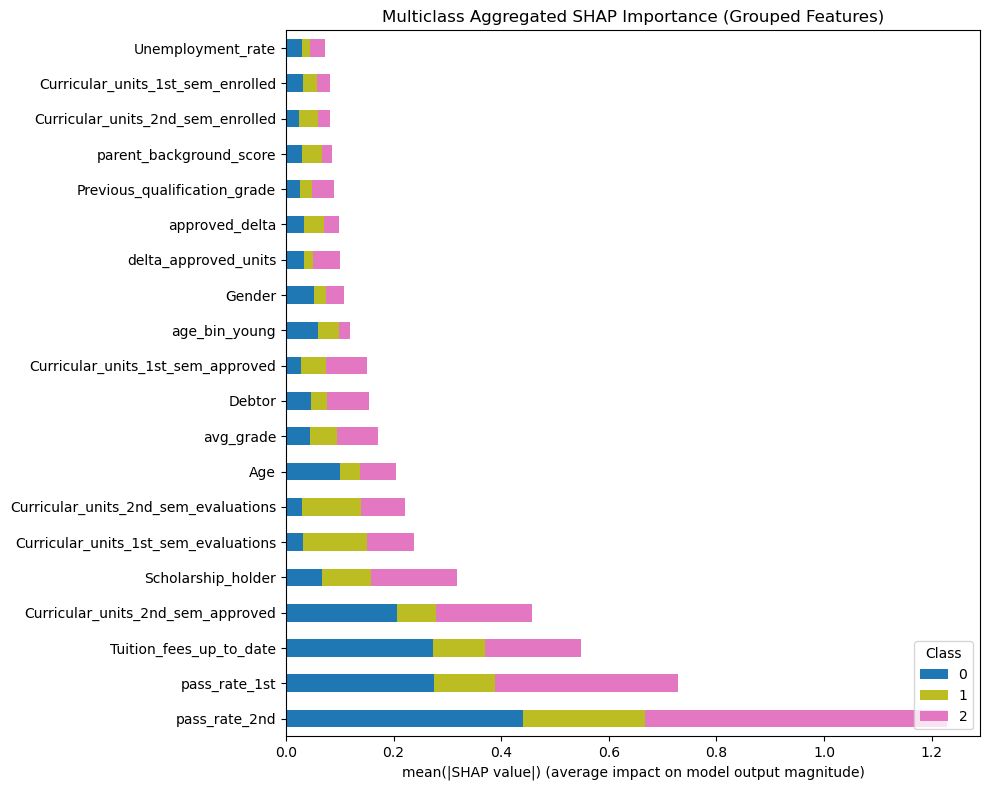

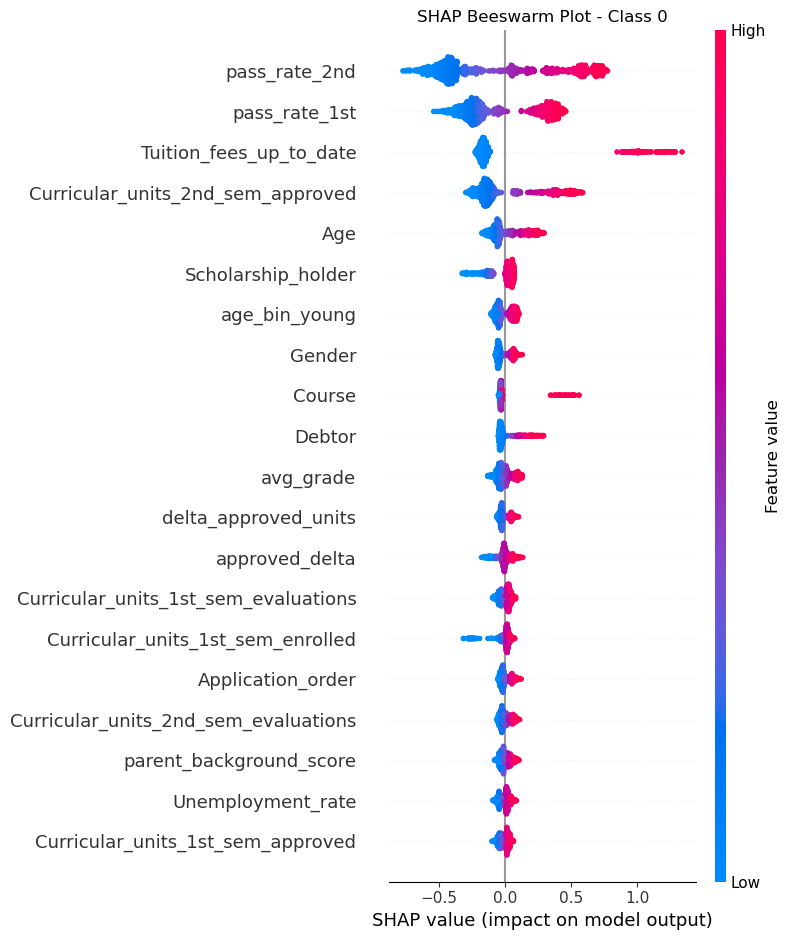

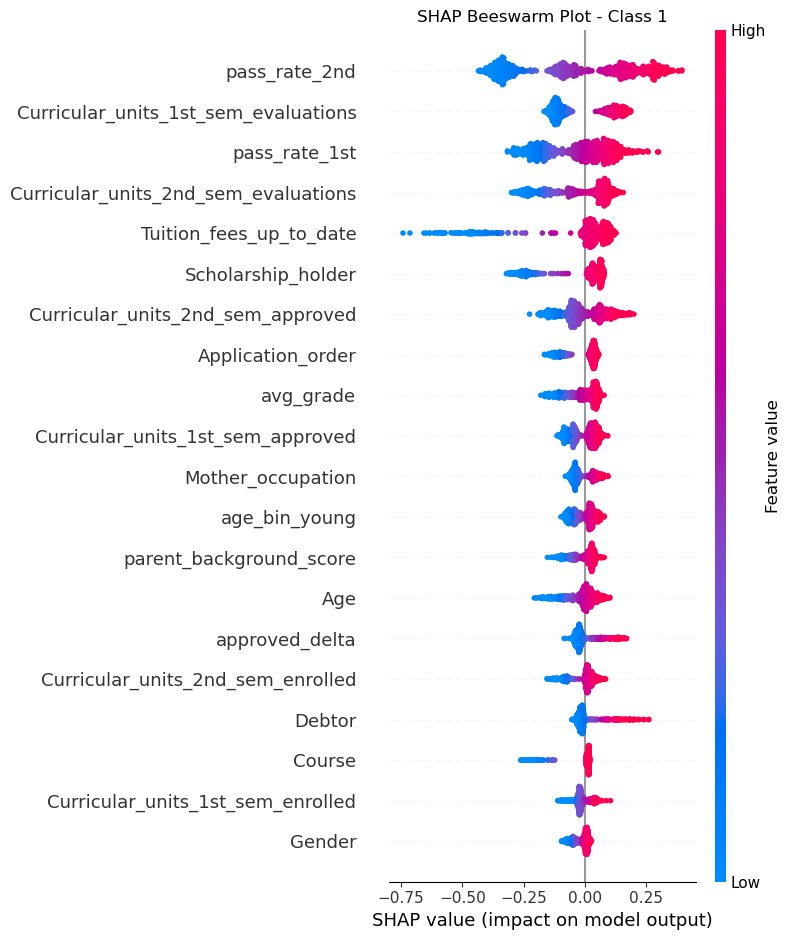

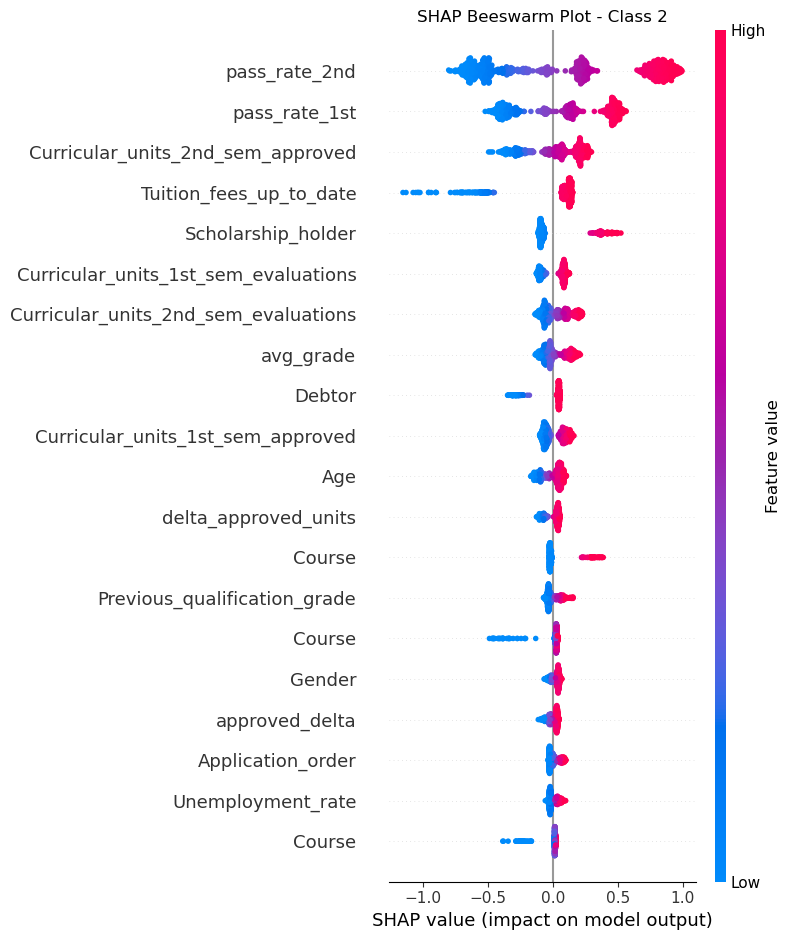

In [29]:
import joblib

#---------------------------------------------
# SHAP values and explainer for Catboost model
#---------------------------------------------

shap_values = joblib.load("../shap_output/shap_values_cb.joblib")
explainer = joblib.load("../shap_output/shap_explainer_cb.joblib")
X_shap = pd.read_csv("../shap_output/X_shap_cb.csv")
feature_names = np.load("../shap_output/feature_names_cb.npy", allow_pickle=True)

#plot_shap_values(shap_values, feature_names, model_cb.classes_)
plot_shap_aggregated(shap_values, feature_names, model_cb.classes_)
plot_beeswarm(shap_values, feature_names, model_cb.classes_)



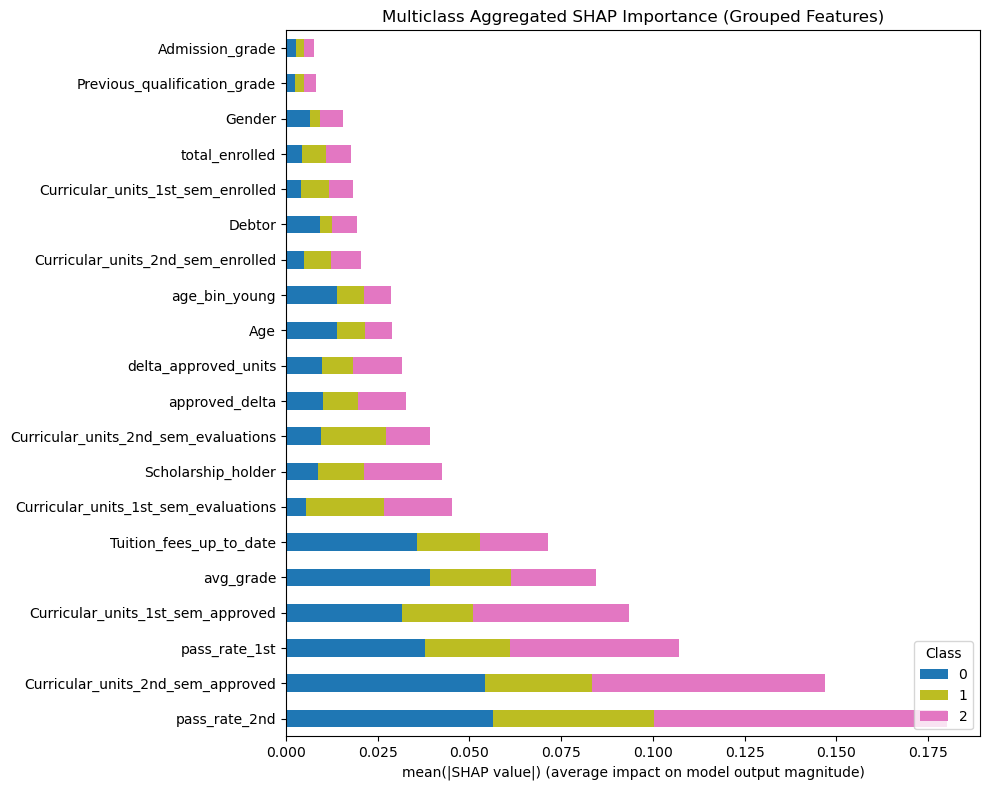

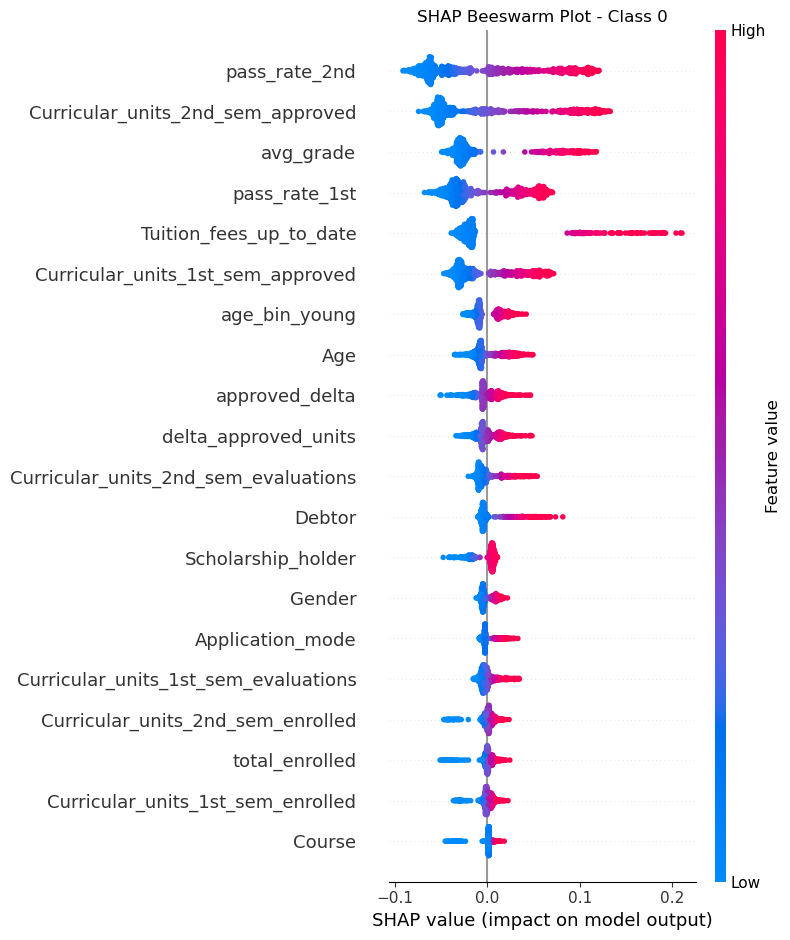

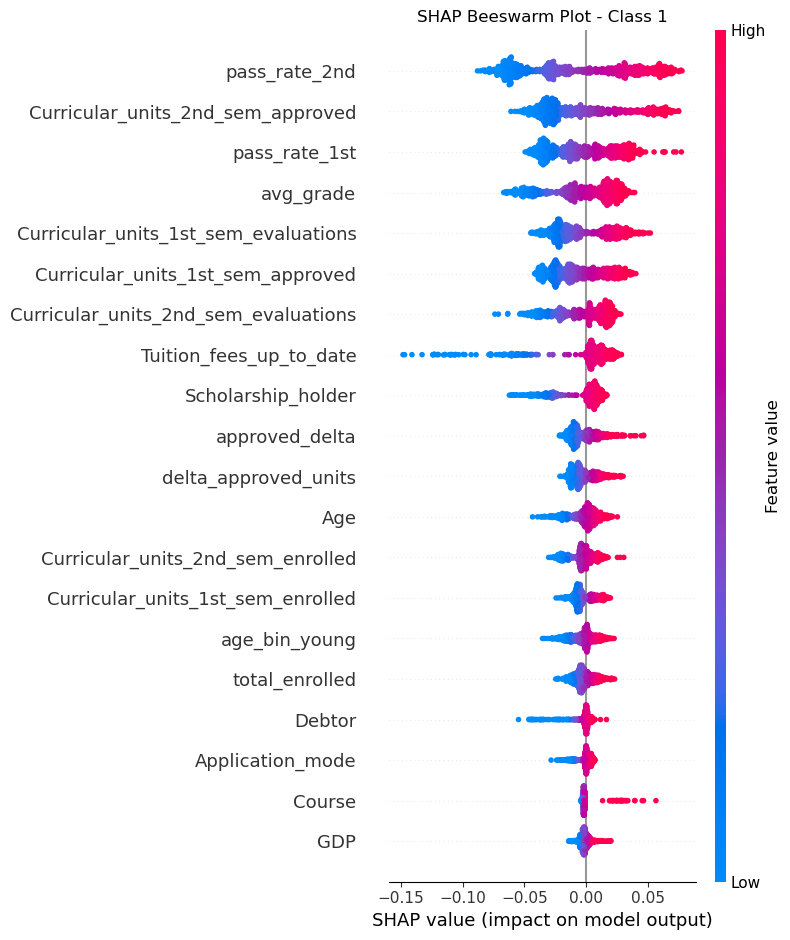

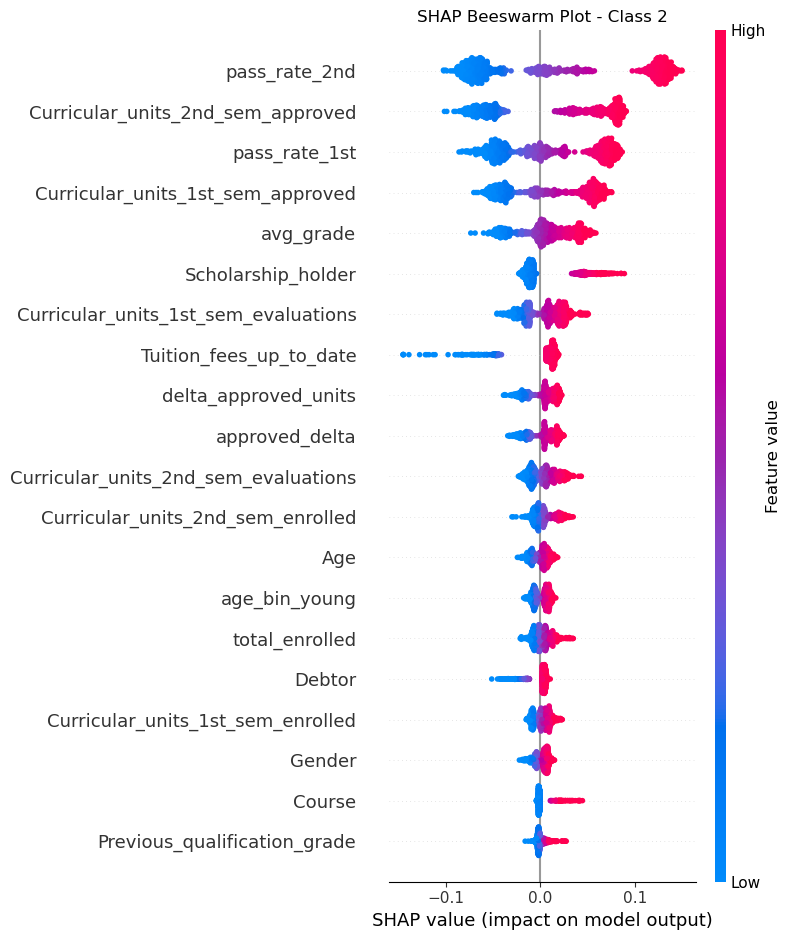

In [22]:
import joblib

#---------------------------------------------
# SHAP values and explainer for Random Forest model
#---------------------------------------------

shap_values = joblib.load("../shap_output/shap_values_rf2.joblib")
explainer = joblib.load("../shap_output/shap_explainer_rf2.joblib")
X_shap = pd.read_csv("../shap_output/X_shap_rf2.csv")
feature_names = np.load("../shap_output/feature_names_rf2.npy", allow_pickle=True)

# plot_shap_values(shap_values, feature_names, model_rf.classes_)
plot_shap_aggregated(shap_values, feature_names, model_rf.classes_)
plot_beeswarm(shap_values, feature_names, model_rf.classes_)



Waterfall plot for class 0


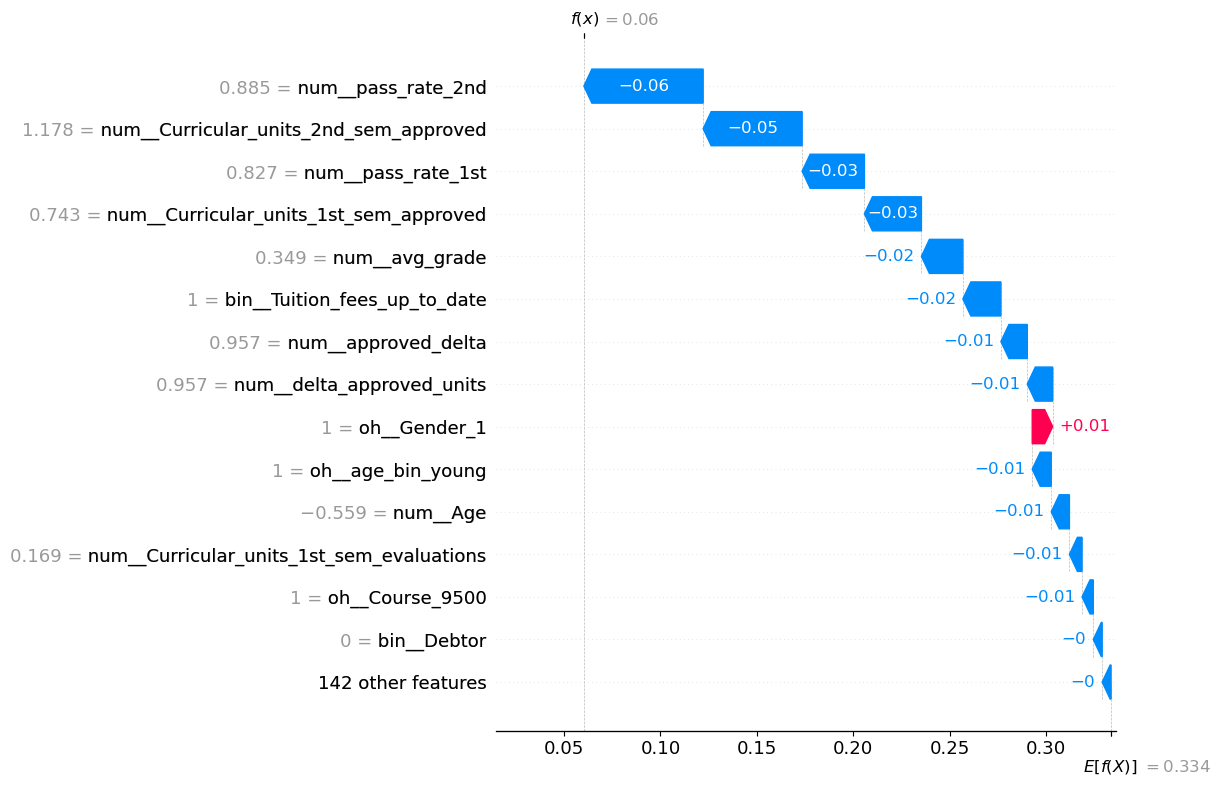

Waterfall plot for class 1


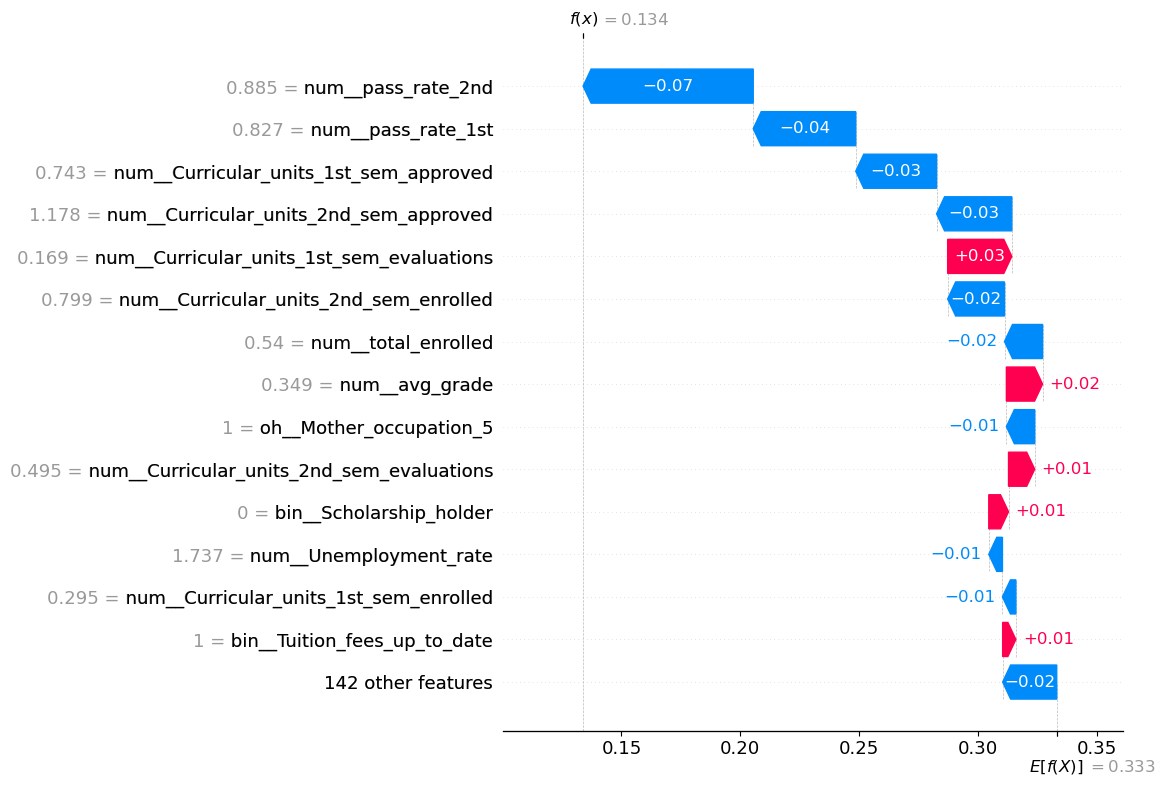

Waterfall plot for class 2


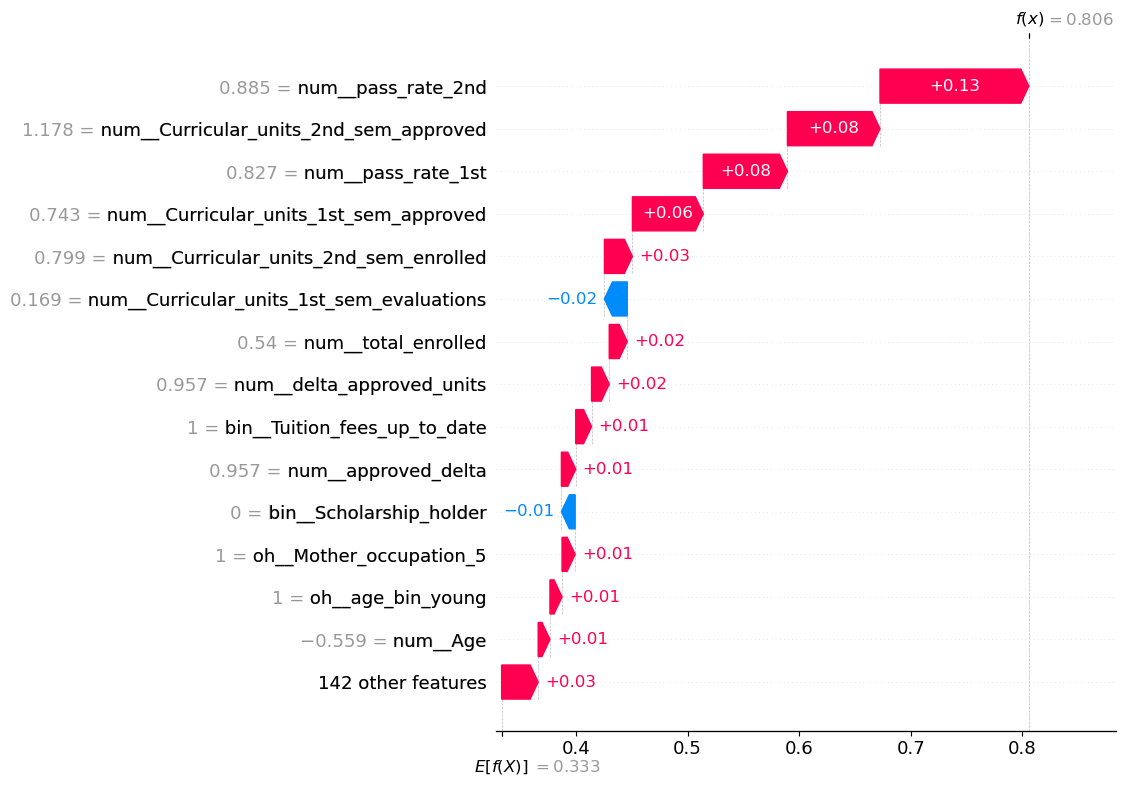

In [ ]:
import shap
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


student_index = 1
model=model_rf

shap_array = joblib.load("../shap_output/shap_values_rf2.joblib")  
explainer = joblib.load("../shap_output/shap_explainer_rf2.joblib")
X_shap = pd.read_csv("../shap_output/X_shap_rf2.csv")
feature_names = np.load("../shap_output/feature_names_rf2.npy", allow_pickle=True)

# --- Create Explanation object manually ---
for class_idx, class_name in enumerate(model.classes_):
    shap_values_instance = shap_array[student_index, :, class_idx]
    base_value = explainer.expected_value[class_idx]
    data_instance = X_shap.iloc[student_index].values

    explanation = shap.Explanation(
        values=shap_values_instance,
        base_values=base_value,
        data=data_instance,
        feature_names=feature_names
    )

    print(f"Waterfall plot for class {class_name}")
    shap.plots.waterfall(explanation, max_display=15)
    plt.show()


## Gini-based

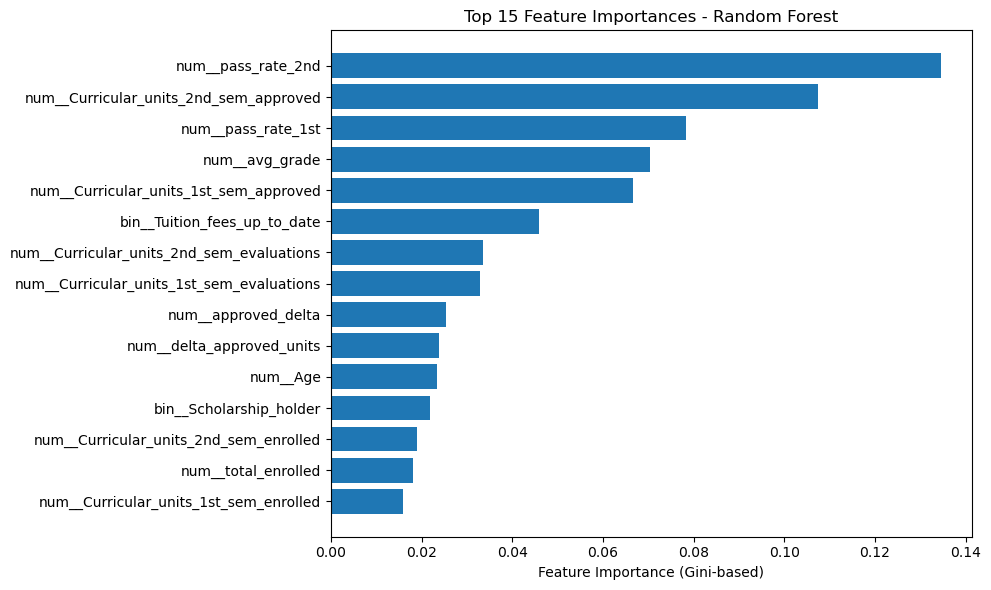

In [ ]:
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


pipeline = model_rf 


feature_names = pipeline.named_steps['preprocessing'].get_feature_names_out()


model = pipeline.named_steps['model']

importances = model.feature_importances_


feat_imp = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)


plt.figure(figsize=(10, 6))
plt.barh(feat_imp['Feature'][:15][::-1], feat_imp['Importance'][:15][::-1])
plt.xlabel('Feature Importance (Gini-based)')
plt.title('Top 15 Feature Importances - Random Forest')
plt.tight_layout()
plt.show()


## Gini-Shap comparison

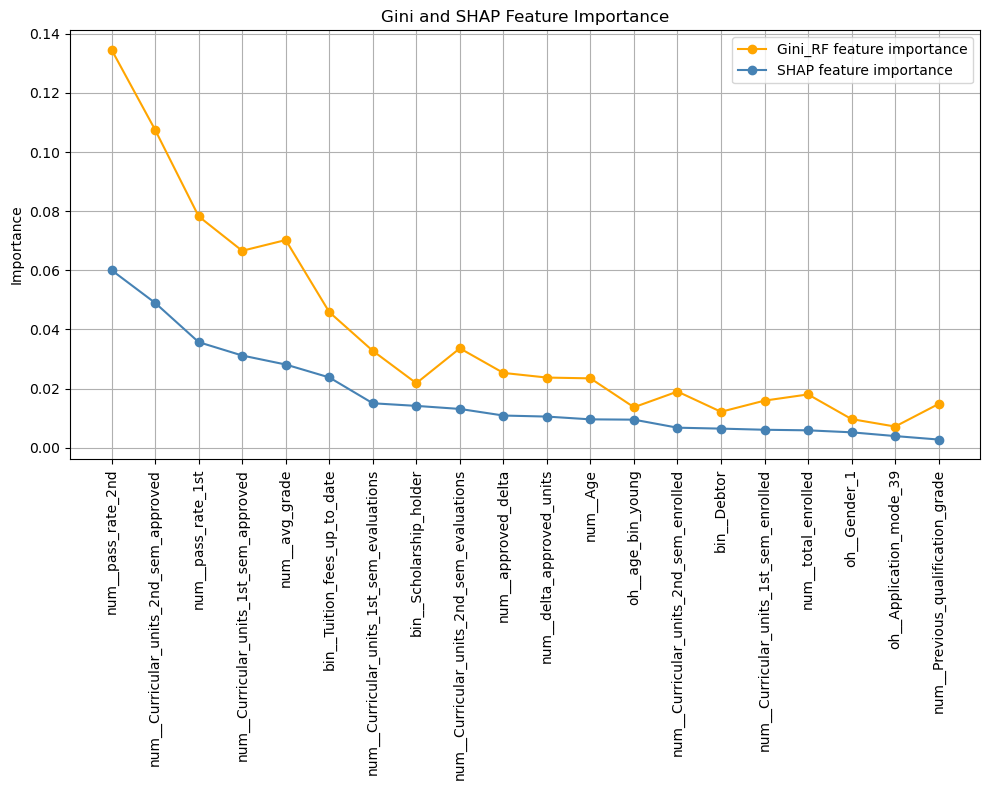

In [ ]:
import matplotlib.pyplot as plt
import shap


# Importanze native Random Forest
rf_model = pipeline.named_steps['model']
rf_importance = rf_model.feature_importances_

# Importanze SHAP
explainer = joblib.load("../shap_output/shap_explainer_rf2.joblib")
shap_values = joblib.load("../shap_output/shap_values_rf2.joblib")

# Media assoluta dei valori SHAP per ogni feature (global importance)
shap_importance = np.abs(shap_values).mean(axis=(0, 2))  # (feature axis = 1)
 # media su tutte le classi e osservazioni

feature_names = pipeline.named_steps['preprocessing'].get_feature_names_out()

df_compare = pd.DataFrame({
    'Feature': feature_names,
    'Gini_RF': rf_importance,
    'SHAP': shap_importance
}).sort_values(by='SHAP', ascending=False)



# Ordina le feature in base all'importanza SHAP 
df_plot = df_compare.sort_values(by='SHAP', ascending=False).reset_index(drop=True)

N = 20
df_plot = df_plot.head(N)

# Plot a linee comparativo
plt.figure(figsize=(10, 8))
plt.plot(df_plot['Gini_RF'].values, marker='o', label='Gini_RF feature importance', color='orange')
plt.plot(df_plot['SHAP'].values, marker='o', label='SHAP feature importance', color='steelblue')

plt.xticks(ticks=np.arange(len(df_plot)), labels=df_plot['Feature'], rotation=90)
plt.ylabel('Importance')
plt.title('Gini and SHAP Feature Importance')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Il confronto tra l’importanza delle feature secondo il metodo nativo di Random Forest (Gini) e il metodo SHAP evidenzia una sostanziale concordanza sulle feature più predittive, ma una significativa divergenza nella distribuzione dell’importanza. Il metodo Gini concentra gran parte del peso su poche variabili, mentre SHAP mostra una distribuzione più regolare, attribuendo rilevanza anche a feature meno dominanti ma costantemente influenti. Ciò suggerisce che SHAP offra una valutazione più stabile e interpretabile, particolarmente utile in contesti in cui è richiesta una spiegazione locale del comportamento del modello.

## Permutation importance

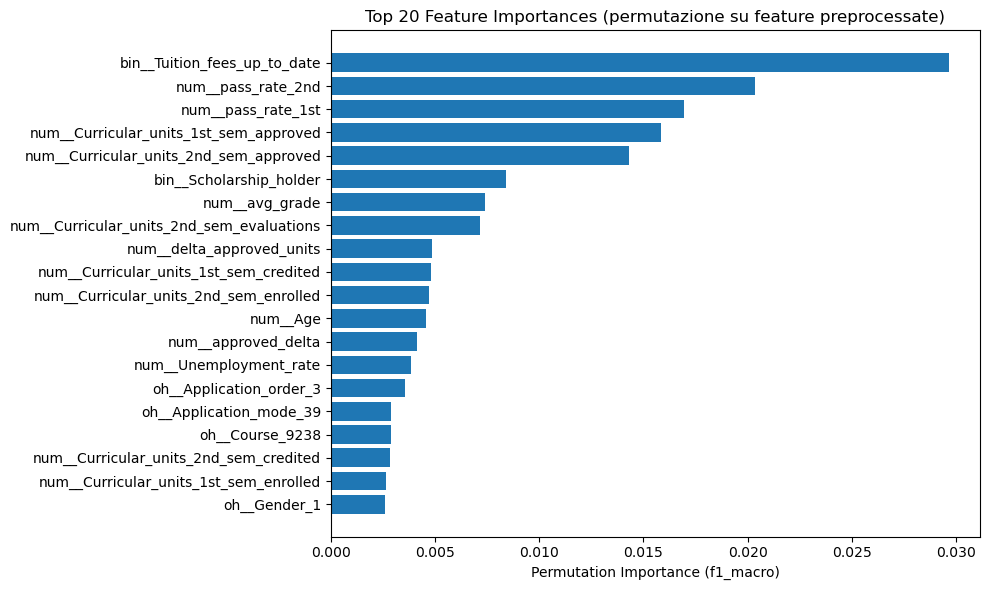

In [ ]:
from sklearn.inspection import permutation_importance
import pandas as pd
import matplotlib.pyplot as plt

preprocessor = pipeline.named_steps['preprocessing']
model = pipeline.named_steps['model']

# --- Trasforma X_test con preprocessing ---
X_test_fe = pipeline.named_steps['feature_transformer'].transform(X_test)
X_test_transformed = preprocessor.transform(X_test_fe)

if hasattr(X_test_transformed, "toarray"):
    X_test_transformed = X_test_transformed.toarray()

feature_names = preprocessor.get_feature_names_out()

# --- Calcola permutation importance ---
result = permutation_importance(
    model,
    X_test_transformed,
    y_test,
    n_repeats=20,
    random_state=42,
    scoring='f1_macro'
)

# --- Crea DataFrame ---
perm_df = pd.DataFrame({
    'Feature': feature_names,
    'Permutation Importance': result.importances_mean
}).sort_values(by='Permutation Importance', ascending=False)

# --- Visualizza le top 20 ---
plt.figure(figsize=(10, 6))
plt.barh(perm_df['Feature'][:20][::-1], perm_df['Permutation Importance'][:20][::-1])
plt.xlabel("Permutation Importance (f1_macro)")
plt.title("Top 20 Feature Importances (permutazione su feature preprocessate)")
plt.tight_layout()
plt.show()


## Gini-SHAP-PI comparison

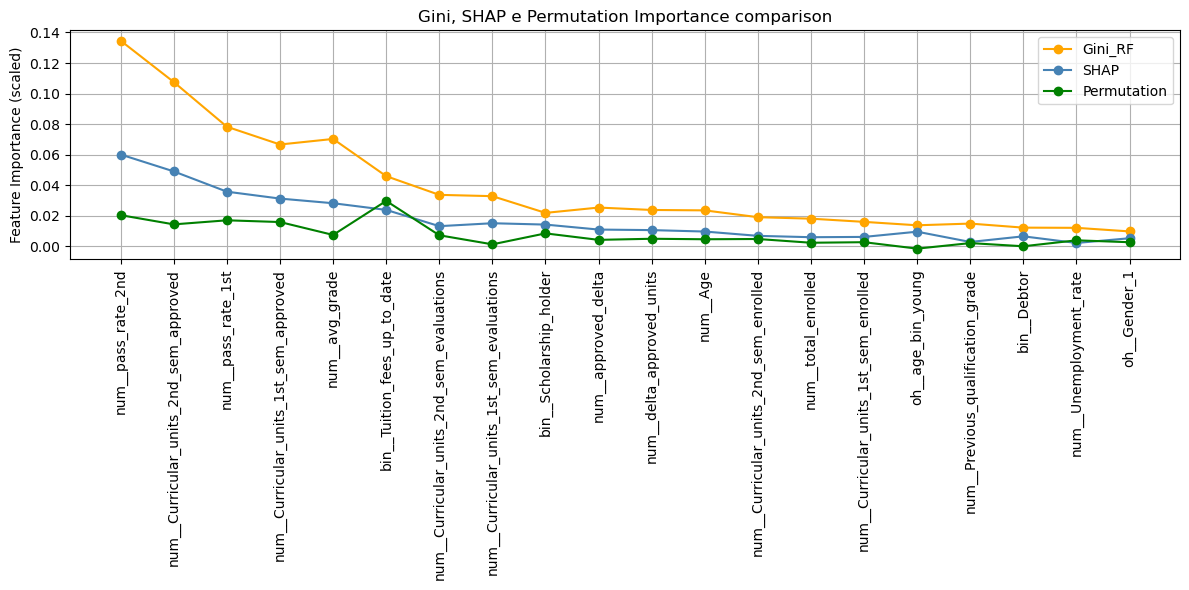

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.inspection import permutation_importance



feature_engineer = pipeline.named_steps.get('feature_transformer', None)
preprocessor = pipeline.named_steps['preprocessing']
model = pipeline.named_steps['model']

X_test_fe = pipeline.named_steps['feature_transformer'].transform(X_test)
X_test_transformed = preprocessor.transform(X_test_fe)

if hasattr(X_test_transformed, "toarray"):
    X_test_transformed = X_test_transformed.toarray()

feature_names = preprocessor.get_feature_names_out()

# --- Gini Importance ---
gini_importance = model.feature_importances_

# --- SHAP Importance ---
shap_importance = np.abs(shap_values).mean(axis=(0, 2))  # aggrega su sample e classi

# --- Permutation Importance ---
perm_result = permutation_importance(
    model,
    X_test_transformed,
    y_test,
    n_repeats=20,
    random_state=42,
    scoring='f1_macro'
)
perm_importance = perm_result.importances_mean

# --- DataFrame unificato ---
df_compare = pd.DataFrame({
    'Feature': feature_names,
    'Gini_RF': gini_importance,
    'SHAP': shap_importance,
    'Permutation': perm_importance
})

# --- Seleziona top 20 (in base a media delle 3) ---
df_compare['avg'] = df_compare[['Gini_RF', 'SHAP', 'Permutation']].mean(axis=1)
df_plot = df_compare.sort_values('avg', ascending=False).head(20)

# --- Plot comparativo ---
plt.figure(figsize=(12, 6))
plt.plot(df_plot['Gini_RF'].values, marker='o', label='Gini_RF', color='orange')
plt.plot(df_plot['SHAP'].values, marker='o', label='SHAP', color='steelblue')
plt.plot(df_plot['Permutation'].values, marker='o', label='Permutation', color='green')
plt.xticks(ticks=np.arange(len(df_plot)), labels=df_plot['Feature'], rotation=90)
plt.ylabel("Feature Importance (scaled)")
plt.title("Gini, SHAP e Permutation Importance comparison")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



Il confronto tra Gini, SHAP e Permutation Importance evidenzia una forte coerenza tra i metodi nella selezione delle feature più predittive, in particolare pass_rate_2nd e Curricular_units_2nd_sem_approved. Tuttavia, il metodo Gini tende a concentrare l'importanza in poche variabili, mentre SHAP e Permutation distribuiscono l'importanza in modo più equilibrato, evidenziando anche effetti più sottili. Questo conferma l’utilità dell’analisi SHAP per una spiegazione più fedele e localmente consistente delle predizioni, rispetto all'importanza nativa dell’algoritmo Random Forest.